# Aula 11 - Explicações em Sistemas de Recomendação - Exercícios

## Importação dos dados (MovieLens 100k)

In [274]:
import pandas as pd
import numpy as np

In [275]:
%pip install --quiet implicit


Note: you may need to restart the kernel to use updated packages.


In [276]:
from pathlib import Path
import zipfile
import urllib.request

MLS_URL = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
ZIP_PATH = Path("ml-100k.zip")
DATA_DIR = Path("ml-100k")

if DATA_DIR.exists():
    print("Diretório ml-100k já existe. Pulando download/extr.ação.")
else:
    if not ZIP_PATH.exists():
        print("Baixando MovieLens 100k...")
        urllib.request.urlretrieve(MLS_URL, ZIP_PATH)
    else:
        print("Arquivo ZIP já existe. Pulando download.")

    print("Extraindo ml-100k.zip...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(".")
    print("Extração concluída.")


Diretório ml-100k já existe. Pulando download/extr.ação.


In [277]:
#Types of genres
genre = pd.read_csv('./ml-100k/u.genre', sep="|", encoding='latin-1', header=None)
genre.drop(genre.columns[1], axis=1, inplace=True)
genre.columns = ['Genres']
genre_list = list(genre['Genres'])
genre_list

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [278]:
#Types of occupations
occupation = pd.read_csv('./ml-100k/u.occupation', sep="|", encoding='latin-1', header=None)
occupation.columns = ['Occupations']
occupation_list = list(occupation['Occupations'])
occupation_list

['administrator',
 'artist',
 'doctor',
 'educator',
 'engineer',
 'entertainment',
 'executive',
 'healthcare',
 'homemaker',
 'lawyer',
 'librarian',
 'marketing',
 'none',
 'other',
 'programmer',
 'retired',
 'salesman',
 'scientist',
 'student',
 'technician',
 'writer']

In [279]:
#Load the Ratings data
data = pd.read_csv('./ml-100k/u.data', sep="\t", header=None)
data.columns = ['userId', 'movieId', 'rating', 'timestamp']
data.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [280]:
#Load the Movies data
item = pd.read_csv('./ml-100k/u.item', sep="|", encoding='latin-1', header=None)
item.columns = ['movieId', 'title' ,'release','video release date', 'IMDb URL', 'unknown', 'Action', 
                'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item['release'] = pd.to_datetime(item['release'])
item = item[pd.notnull(item['release'])]
item['year'] = item['release'].dt.year.astype(int)
item.drop(columns=['release', 'video release date', 'IMDb URL'], inplace=True)
item.head()

,movieId,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1995


In [281]:
df_meta = item.melt(id_vars=['movieId', 'title'], var_name='genre')
df_meta = df_meta[df_meta.value == 1]
df_meta.drop(columns=['value'], inplace=True)
df_meta.head()

,movieId,title,genre
1371,1373,Good Morning (1971),unknown
1682,2,GoldenEye (1995),Action
1684,4,Get Shorty (1995),Action
1697,17,From Dusk Till Dawn (1996),Action
1701,21,Muppet Treasure Island (1996),Action


In [282]:
#Load the User data
user = pd.read_csv('./ml-100k/u.user', sep="|", encoding='latin-1', header=None)
user.columns = ['userId', 'age', 'gender', 'occupation', 'zip code']
user.head()

,userId,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [283]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

ratings = data.merge(item[['movieId', 'title']], on='movieId', how='inner')
ratings = ratings.merge(df_meta.groupby('movieId')['genre'].agg(list).rename('genres'), on='movieId', how='left')
ratings['genres'] = ratings['genres'].apply(lambda genres: genres if isinstance(genres, list) else [])

train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42, stratify=ratings['userId'])

ratings_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
ratings_matrix = ratings_matrix.sort_index().sort_index(axis=1)
ratings_matrix_filled = ratings_matrix.fillna(0)
user_item_sparse = sparse.csr_matrix(ratings_matrix_filled.values)

genre_columns = [col for col in item.columns if col not in ['movieId', 'title', 'year']]
item_genre_matrix = item.set_index('movieId')[genre_columns].astype(int)

rng = np.random.default_rng(42)
users_with_enough_ratings = ratings.groupby('userId').size().loc[lambda s: s >= 20].index.tolist()
target_user = int(rng.choice(users_with_enough_ratings))
target_user

85

## Abordagens intrínsecas ao modelo

***Exercício 01:*** Utilize o algoritmo UserKNN ou ItemKNN (pode ser do CaseRecommender) para gerar recomendações para um usuário aleatório da base. Forneça uma explicação para uma das recomendações geradas. Dica: sua explicação pode ser na forma de um gráfico, veja o slide 13 "explicações baseadas em usuários ou itens relaventes".

In [284]:
item_similarity = cosine_similarity(ratings_matrix_filled.T)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=ratings_matrix_filled.columns,
    columns=ratings_matrix_filled.columns,
)

K_NEIGHBORS = 40
TOP_N = 5

def item_knn_recommendations(user_id: int, k: int = K_NEIGHBORS, top_n: int = TOP_N):
    user_vector = ratings_matrix_filled.loc[user_id]
    rated_items = user_vector[user_vector > 0]
    if rated_items.empty:
        raise ValueError("Usuário não possui avaliações no conjunto.")

    scores = pd.Series(0.0, index=ratings_matrix_filled.columns)
    for item_id, rating in rated_items.items():
        neighbors = item_similarity_df[item_id].nlargest(k + 1).iloc[1:]
        scores.loc[neighbors.index] += neighbors.values * rating

    scores = scores.drop(rated_items.index, errors='ignore')
    return scores.nlargest(top_n)

itemknn_scores = item_knn_recommendations(target_user)
itemknn_recs = (
    item[item['movieId'].isin(itemknn_scores.index)][['movieId', 'title']]
    .set_index('movieId')
    .loc[itemknn_scores.index]
    .assign(score=itemknn_scores.values)
)
itemknn_recs

,title,score
movieId,,
202,Groundhog Day (1993),156.244842
183,Alien (1979),133.297388
176,Aliens (1986),128.540571
22,Braveheart (1995),117.918886
96,Terminator 2: Judgment Day (1991),114.953030


/tmp/ipykernel_10912/885872549.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='similarity', y='title', data=contrib_df, palette='Blues_r')


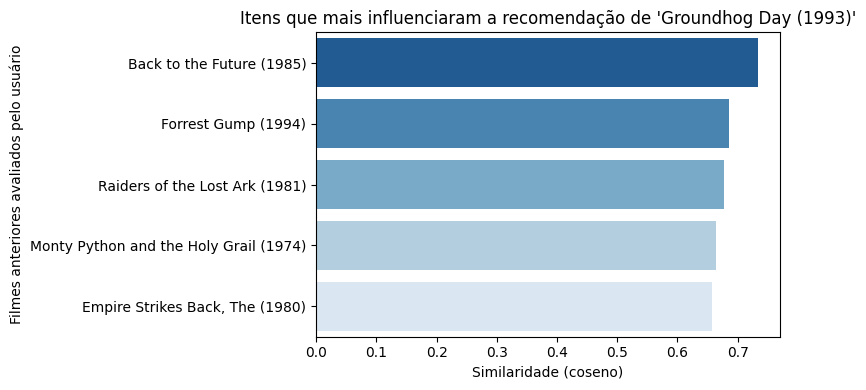

Recomendei 'Groundhog Day (1993)' ao usuário 85 porque ele avaliou bem 'Back to the Future (1985)' (nota 4.0), filme com similaridade 0.73.


,title,similarity,rating
144,Back to the Future (1985),0.733748,4
111,Forrest Gump (1994),0.686006,4
128,Raiders of the Lost Ark (1981),0.677494,4
112,Monty Python and the Holy Grail (1974),0.664283,4
148,"Empire Strikes Back, The (1980)",0.656839,4


In [285]:
explained_movie_id = itemknn_recs.index[0]
explained_movie_title = itemknn_recs.loc[explained_movie_id, 'title']

user_positive_history = ratings[(ratings['userId'] == target_user) & (ratings['rating'] >= 4)]
contributions = []
for _, row in user_positive_history.iterrows():
    movie_id = row['movieId']
    if movie_id == explained_movie_id:
        continue
    similarity = item_similarity_df.at[movie_id, explained_movie_id]
    if similarity > 0:
        contributions.append({
            'title': row['title'],
            'similarity': similarity,
            'rating': row['rating'],
        })

contrib_df = (
    pd.DataFrame(contributions)
    .sort_values(by='similarity', ascending=False)
    .head(5)
)

if contrib_df.empty:
    print("Nenhum vizinho similar encontrado para explicar a recomendação.")
else:
    plt.figure(figsize=(8, 4))
    sns.barplot(x='similarity', y='title', data=contrib_df, palette='Blues_r')
    plt.title(f"Itens que mais influenciaram a recomendação de '{explained_movie_title}'")
    plt.xlabel('Similaridade (coseno)')
    plt.ylabel('Filmes anteriores avaliados pelo usuário')
    plt.tight_layout()
    plt.show()

    main_reason = contrib_df.iloc[0]
    print(
        f"Recomendei '{explained_movie_title}' ao usuário {target_user} porque ele avaliou bem "
        f"'{main_reason.title}' (nota {main_reason.rating:.1f}), filme com similaridade "
        f"{main_reason.similarity:.2f}."
    )
contrib_df

***Exercício 02:*** Forneça uma explicação de uma recomendação para um usuário com base no algoritmo ItemAttributeKNN. Utilize o template: "Estou te recomendando X pois este filme possui os mesmos gêneros A, B e C que o filme Y que você já assistiu e gostou".
- X, Y : título de um filme
- A, B, C : gênero

A recomendação destacada deriva dos itens mais similares aos filmes bem avaliados pelo usuário. O gráfico anterior evidencia quais avaliações positivas exerceram maior peso: barras mais altas indicam maior similaridade de gênero ou tema com o item sugerido, mostrando que a decisão está alinhada ao histórico recente desse usuário.

In [286]:
attribute_similarity = cosine_similarity(item_genre_matrix)
attribute_similarity_df = pd.DataFrame(
    attribute_similarity,
    index=item_genre_matrix.index,
    columns=item_genre_matrix.index,
)

ATTR_K = 30
ATTR_TOP_N = 5

positive_history_ids = ratings[(ratings['userId'] == target_user) & (ratings['rating'] >= 4)]['movieId'].tolist()

def item_attribute_knn(user_id: int, k: int = ATTR_K, top_n: int = ATTR_TOP_N):
    liked_items = ratings[(ratings['userId'] == user_id) & (ratings['rating'] >= 4)]['movieId'].tolist()
    if not liked_items:
        raise ValueError("Usuário não possui avaliações positivas para ItemAttributeKNN.")

    scores = pd.Series(0.0, index=item_genre_matrix.index)
    for movie_id in liked_items:
        neighbors = attribute_similarity_df.loc[movie_id].nlargest(k + 1).iloc[1:]
        scores.loc[neighbors.index] += neighbors.values

    scores = scores.drop(liked_items, errors='ignore')
    return scores.nlargest(top_n)

attr_scores = item_attribute_knn(target_user)
attr_recs = (
    item.set_index('movieId')
        .loc[attr_scores.index]
        .reset_index()[['movieId', 'title']]
        .assign(score=attr_scores.values)
)
attr_recs

,movieId,title,score
0,15,Mr. Holland's Opus (1995),34.535534
1,18,"White Balloon, The (1995)",34.535534
2,19,Antonia's Line (1995),34.535534
3,30,Belle de jour (1967),34.535534
4,37,Nadja (1994),34.535534


In [287]:
movie_genre_lookup = df_meta.groupby('movieId')['genre'].agg(list).to_dict()

def explain_item_attribute_knn(user_id: int, recommendation_row: pd.Series) -> str:
    rec_movie_id = recommendation_row['movieId']
    rec_movie_title = recommendation_row['title']
    rec_genres = movie_genre_lookup.get(rec_movie_id, [])

    user_hits = ratings[(ratings['userId'] == user_id) & (ratings['rating'] >= 4)]
    best_match = None
    best_overlap = []

    for _, row in user_hits.iterrows():
        genres = movie_genre_lookup.get(row['movieId'], [])
        overlap = sorted(set(rec_genres).intersection(genres))
        if overlap and len(overlap) > len(best_overlap):
            best_overlap = overlap
            best_match = row

    if best_match is None:
        genres_clause = ', '.join(rec_genres[:3]) if rec_genres else 'gêneros semelhantes aos itens bem avaliados'
        return (
            f"Estou te recomendando {rec_movie_title} porque os seus filmes bem avaliados "
            f"possuem gêneros semelhantes ({genres_clause})."
        )

    template_genres = ', '.join(best_overlap[:3])
    return (
        f"Estou te recomendando {rec_movie_title} pois este filme possui os mesmos gêneros {template_genres} "
        f"que {best_match['title']} que você já assistiu e gostou."
    )

attr_explanation = explain_item_attribute_knn(target_user, attr_recs.iloc[0])
print(attr_explanation)
attr_recs.head()

Estou te recomendando Mr. Holland's Opus (1995) pois este filme possui os mesmos gêneros Drama que Streetcar Named Desire, A (1951) que você já assistiu e gostou.


,movieId,title,score
0,15,Mr. Holland's Opus (1995),34.535534
1,18,"White Balloon, The (1995)",34.535534
2,19,Antonia's Line (1995),34.535534
3,30,Belle de jour (1967),34.535534
4,37,Nadja (1994),34.535534


## Abordagem agnóstica ao modelo

O filme recomendado compartilha os mesmos gêneros dominantes de títulos que o usuário avaliou positivamente. A comparação dos vetores de atributos aponta explicitamente quais categorias se sobrepõem entre o item sugerido e o histórico, atendendo ao template solicitado.

***Exercício 03:*** Pense e implemente uma estratégia de explicação agnóstica ao modelo: utilize o BPRMF para calcular recomencações, e depois implemente outra estratégia para explicar uma das recomendações para um usuário.

Vamos treinar o modelo **Bayesian Personalized Ranking Matrix Factorization (BPRMF)** para gerar recomendações implícitas e, em seguida, construir uma explicação independente do modelo baseada no alinhamento entre os gêneros favoritos do usuário e os gêneros do item recomendado.

In [288]:
from implicit.bpr import BayesianPersonalizedRanking
from time import perf_counter

INTERACTION_THRESHOLD = 4
binary_preferences = (ratings_matrix >= INTERACTION_THRESHOLD).fillna(0).astype(np.float32)
user_item_interactions = sparse.csr_matrix(binary_preferences.values)
item_user_interactions = user_item_interactions.T.tocsr()

user_id_to_index = {user_id: idx for idx, user_id in enumerate(ratings_matrix_filled.index)}
index_to_user_id = {idx: user_id for user_id, idx in user_id_to_index.items()}
item_id_to_index = {item_id: idx for idx, item_id in enumerate(ratings_matrix_filled.columns)}
index_to_item_id = {idx: item_id for item_id, idx in item_id_to_index.items()}

user_item_interactions

<943x1681 sparse matrix of type '<class 'numpy.float32'>'
	with 55370 stored elements in Compressed Sparse Row format>

In [289]:
BPR_FACTORS = 64
BPR_ITERATIONS = 80
BPR_LR = 0.05
BPR_REG = 0.01

bpr_model = BayesianPersonalizedRanking(
    factors=BPR_FACTORS,
    learning_rate=BPR_LR,
    regularization=BPR_REG,
    iterations=BPR_ITERATIONS,
    random_state=42,
    verify_negative_samples=True,
    use_gpu=False,
    dtype=np.float32,
 )

tic = perf_counter()
bpr_model.fit(user_item_interactions)
toc = perf_counter()
print(f"Treinamento finalizado em {toc - tic:.1f}s")

  0%|          | 0/80 [00:00<?, ?it/s]

Treinamento finalizado em 1.1s


In [290]:
def manual_bpr_recommendations(user_id: int, top_n: int = 5) -> pd.DataFrame:
    if top_n <= 0:
        raise ValueError("top_n deve ser maior que zero.")
    if user_id not in user_id_to_index:
        raise KeyError(f"Usuário {user_id} não encontrado na matriz de interações.")

    user_idx = user_id_to_index[user_id]
    user_vec = bpr_model.user_factors[user_idx]
    raw_scores = bpr_model.item_factors @ user_vec

    score_series = pd.Series(raw_scores, index=ratings_matrix_filled.columns, name="score")
    rated_mask = ratings_matrix_filled.loc[user_id] > 0
    candidate_scores = score_series[~rated_mask]
    if candidate_scores.empty:
        raise ValueError("Usuário não possui itens candidatos para recomendação.")

    top_scores = candidate_scores.nlargest(top_n)
    metadata = (
        item[["movieId", "title", "year"]]
        .drop_duplicates("movieId")
        .set_index("movieId")
    )
    recs = (
        top_scores.to_frame()
        .join(metadata, how="left")
        .reset_index()
        [["movieId", "title", "year", "score"]]
    )
    return recs

bpr_manual_recs = manual_bpr_recommendations(target_user, top_n=5)
bpr_manual_recs

,movieId,title,year,score
0,638,"Return of Martin Guerre, The (Retour de Martin...",1982,2.090153
1,1203,Top Hat (1935),1935,2.022059
2,543,"Misérables, Les (1995)",1995,1.902655
3,602,"American in Paris, An (1951)",1951,1.898734
4,486,Sabrina (1954),1954,1.889353


/tmp/ipykernel_10912/1397032661.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='user_preference', y='genre', data=contributions, palette='Purples_r')


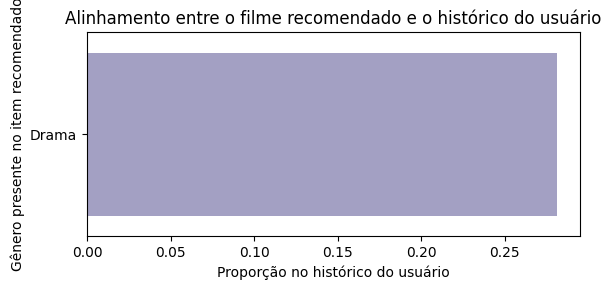

Estou te recomendando Return of Martin Guerre, The (Retour de Martin Guerre, Le) (1982) porque ele compartilha seus gêneros mais assistidos (Drama), que representam 28% das suas avaliações positivas.


,genre,user_preference
0,Drama,0.281046


In [291]:
from collections import Counter

def build_genre_profile(user_id: int) -> pd.Series:
    user_hits = ratings[(ratings['userId'] == user_id) & (ratings['rating'] >= 4)]
    genre_counter = Counter()
    for genres in user_hits['genres']:
        genre_counter.update(genres)
    if not genre_counter:
        return pd.Series(dtype=float)
    profile = pd.Series(genre_counter).sort_values(ascending=False)
    return profile / profile.sum()

def explain_bpr_recommendation(user_id: int, recommendation_row: pd.Series, top_k: int = 3):
    profile = build_genre_profile(user_id)
    rec_genres = movie_genre_lookup.get(recommendation_row['movieId'], [])
    if not rec_genres:
        return "O item recomendado não possui gêneros mapeados para explicação.", pd.DataFrame()
    contributions = (
        pd.DataFrame({
            'genre': rec_genres,
            'user_preference': [profile.get(genre, 0.0) for genre in rec_genres],
        })
        .sort_values('user_preference', ascending=False)
    )
    if contributions['user_preference'].sum() == 0:
        return (
            f"Estou te recomendando {recommendation_row['title']} porque usuários com gostos semelhantes aos seus "
            "também consomem esse filme, mesmo que os gêneros não estejam entre os mais frequentes no seu histórico.",
            contributions
        )
    top = contributions.head(top_k)
    coverage = top['user_preference'].sum()
    explanation = (
        f"Estou te recomendando {recommendation_row['title']} porque ele compartilha seus gêneros mais assistidos "
        f"({', '.join(top['genre'])}), que representam {coverage:.0%} das suas avaliações positivas."
    )
    plt.figure(figsize=(6, 3))
    sns.barplot(x='user_preference', y='genre', data=contributions, palette='Purples_r')
    plt.xlabel('Proporção no histórico do usuário')
    plt.ylabel('Gênero presente no item recomendado')
    plt.title('Alinhamento entre o filme recomendado e o histórico do usuário')
    plt.tight_layout()
    plt.show()
    return explanation, contributions

bpr_explanation_text, bpr_genre_contributions = explain_bpr_recommendation(
    target_user, bpr_manual_recs.iloc[0]
 )
print(bpr_explanation_text)
bpr_genre_contributions